My name is Nathan Crock and I am in love. 

The object of my adoration is a bubbly, vibrant soul named Nuria Gutiérrez Sosa. I want to show her how special she is to me. The usual, flowers, poetry, music and art just won't do. I want to give her something more unique. Something personal - coming from me. So I will give her math. Please try not to faint from how overwhelmingly romantic this is. 

I have documented the journey in this write-up. There is not too much code, but I have ommitted it by default for easier reading. If you desire, the code can be viewed by clicking the button below.

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Toggle Code On/Off"></form>''')

In [2]:
import numpy as np
import matplotlib as mpl
mpl.use('nbagg')
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage.color import rgb2gray

One of our first big trips together was to California for my friend, <a href="https://enjalot.github.io/">Ian Johnson's</a>, wedding.  After the wedding she and I explored the city together and took this photo.

<IPython.core.display.Javascript object>


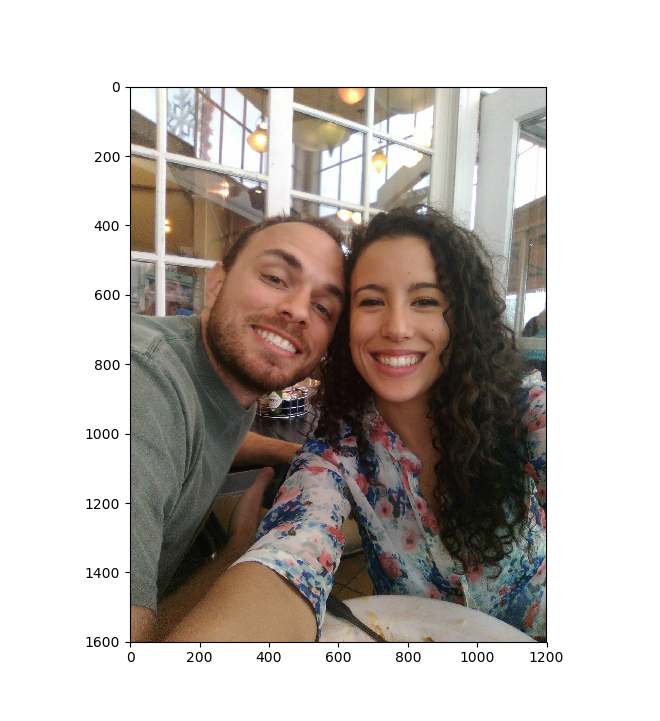

In [23]:
full_image = plt.imread('n&n.jpg')
plt.imshow(full_image); plt.show()

This is day where I began to fall in love with her. We took this picture after brunch. It was a reply to my mother's "How is the trip going?". This is the first picture of us that my family saw. It is special to me, so I want to turn this into math... My plan will be to extract the pertinent edges in the image, then apply some approximation algorithms to find the equations of the edges. Using the coefficients learned, I will write out all of the equations and plot them to recreate this wonderful day, mathematically! For starters, lets just hit the original image with some edge detection and segmentation algorithms and see what we've got.

Let's just see what Canny's edge detector can do to the original image. Canny only works on grayscale images so we'll convert it and then call canny in the scikit-image feature library.

<IPython.core.display.Javascript object>


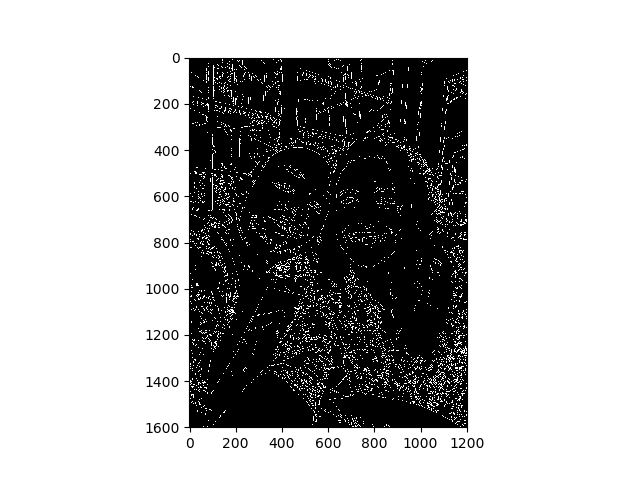

In [24]:
from skimage import feature, img_as_float
bw_image = rgb2gray(img_as_float(full_image))
edges = feature.canny(bw_image)
plt.imshow(edges, cmap='gray'); plt.show() 

There's a whole lot going on there... Too much. Time to tinker with the parameters. We'll probably have to set the Gaussian blur radius pretty high and modify the edge connectivity thresholds...

<IPython.core.display.Javascript object>


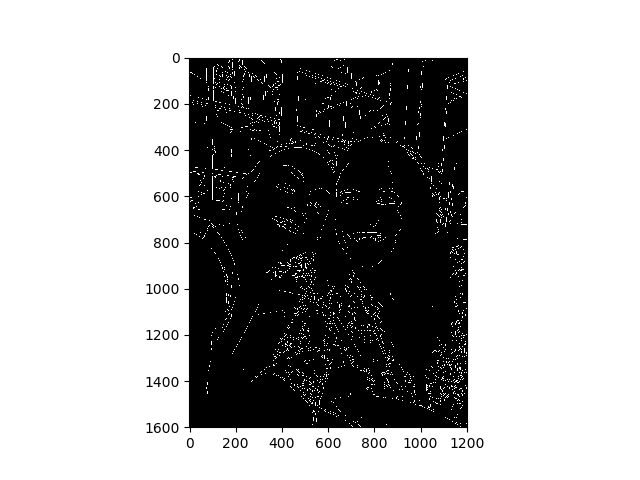

In [25]:
edges = feature.canny(bw_image, sigma=2)
plt.imshow(edges, cmap='gray'); plt.show()

So after tinkering with some parameters, it looks like if we set the blur radius high enough to washout some of the high frequency signal, then we lose information on the faces. So I'm going to aim at solving an easier problem. I opened the image into gimp and cropped the background out.

<IPython.core.display.Javascript object>


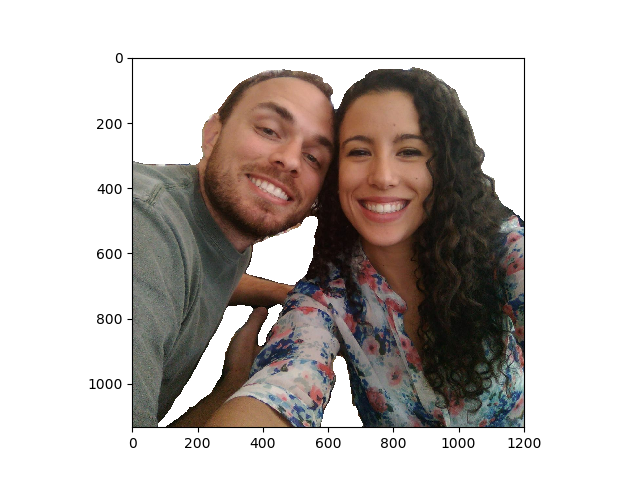

In [26]:
cropped_image = plt.imread('n&n_cleaned.jpg')
plt.imshow(cropped_image); plt.show()

This looks to be an easier problem. We will see if Canny's edge detector can handle it.

<IPython.core.display.Javascript object>


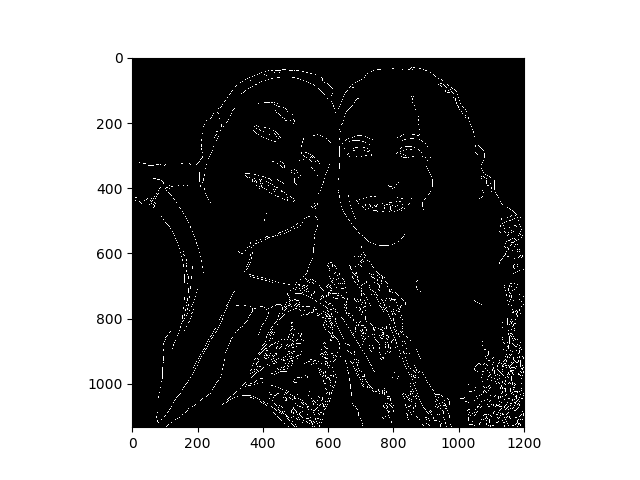

In [27]:
bw_cropped_image = rgb2gray(img_as_float(cropped_image))
edges = feature.canny(bw_cropped_image, sigma=2)
plt.imshow(edges, cmap='gray'); plt.show()

Better, but her shirt is still proving a little troublesome... So I'm going to cheat a bit more and apply some blurring in gimp...

<IPython.core.display.Javascript object>


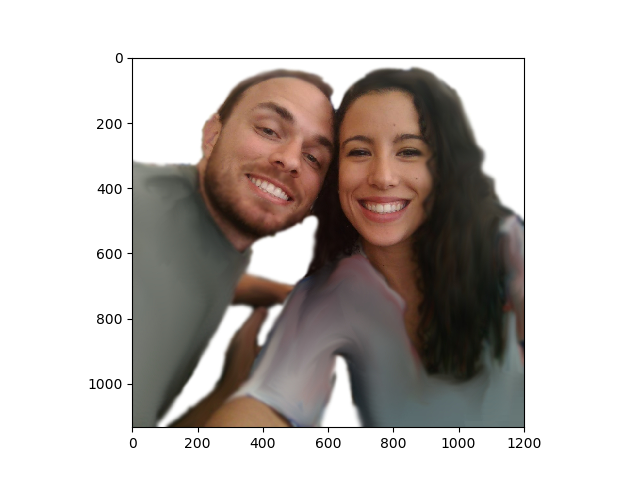

In [28]:
blurred_image = plt.imread('n&n_blurred.jpg')
plt.imshow(blurred_image); plt.show()

<IPython.core.display.Javascript object>


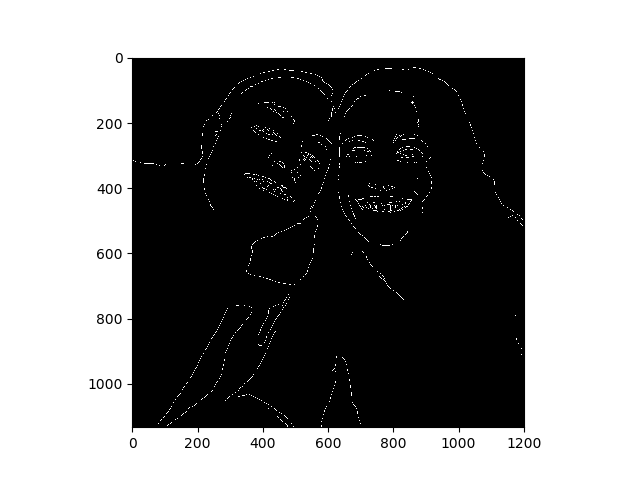

In [29]:
bw_blurred_image = rgb2gray(img_as_float(blurred_image))
edges = feature.canny(bw_blurred_image, sigma=1.5)
plt.imshow(edges, cmap='gray'); plt.show()

So... This is kind of what I had in mind - minus the whole looking like dead zombies thing... I need a new idea. Okay, I'm going to apply some filters to accentuate the edges and then convert the whole image to gray scale. BUT, then I am going to cluster the pixels in color space with only 2 clusters. This will force the grayscale image to become a black and white image, while intelligently extracting the edges.

Okay, so I applied a photocopy filter to the previous unblurred image and got this as a result.

<IPython.core.display.Javascript object>


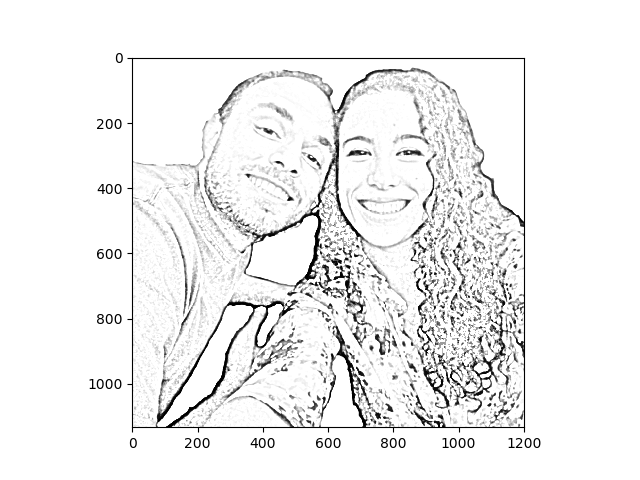

In [30]:
rgb_pc_image = plt.imread('n&n_pc.jpg')
rgb_pc_image = img_as_float(rgb_pc_image)
img_shape = rgb_pc_image.shape
plt.imshow(rgb_pc_image) # It is displayed in only black and white, but it has all three channels hence the rgb
plt.show()

So... cool looking image, but this will make the canny algorithm blow up. Her hair, lovely as it is, is getting in the way of everything - as always. Okay, let's try the same photocopy filter on the previous blurred image and see what we get.

<IPython.core.display.Javascript object>


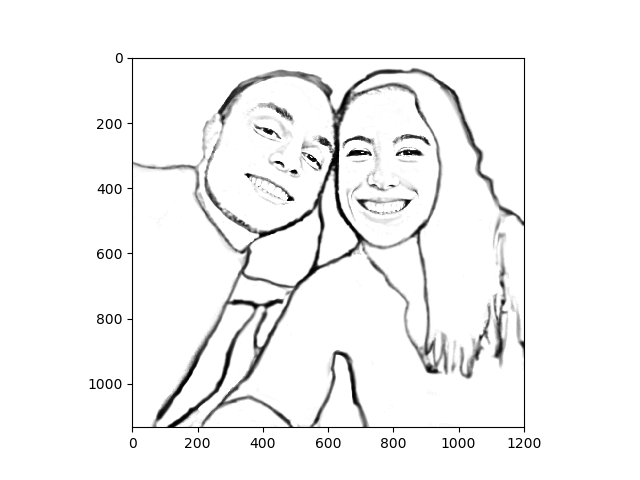

In [31]:
rgb_pc_image = plt.imread('n&n_pc2.jpg')
rgb_pc_image = img_as_float(rgb_pc_image)
img_shape = rgb_pc_image.shape
plt.imshow(rgb_pc_image) # It is displayed in only black and white, but it has all three channels hence the rgb
plt.show()

This is looking much better, but I need to go a step further and cluster the 256 different colors into only 2 in color space. This will help get rid of the shadows. I do this with the simplest of density based clustering algorithms, the tried and true kmeans.

In [32]:
from sklearn.cluster import KMeans
kmeans = KMeans(2).fit(np.reshape(rgb_pc_image, (-1,3)))

After the pixels have been clustered in color space, I need to rerender the newly quantized image with each pixel colored by its associated cluster.

In [33]:
quantized_image = np.ndarray(img_shape)
rows, cols, channels = img_shape
for row in range(rows):
    for col in range(cols):
        quantized_image[row,col] = kmeans.cluster_centers_[kmeans.labels_[row*cols+col]]

<IPython.core.display.Javascript object>


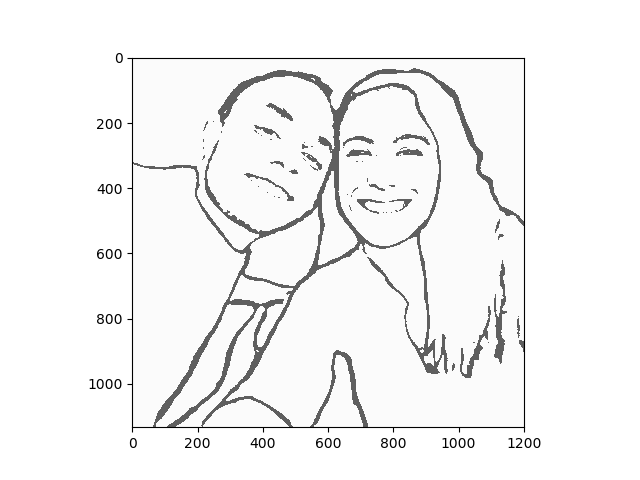

In [34]:
plt.imshow(quantized_image); plt.show()

So this is cool! We've made progress. Now let's see what Canny can do with this.

<IPython.core.display.Javascript object>


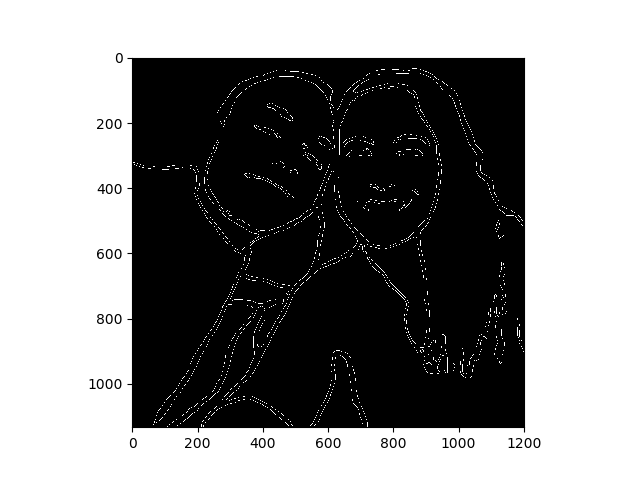

In [35]:
edges = feature.canny(rgb2gray(quantized_image), sigma=2, low_threshold=0.01, high_threshold=0.9)
plt.imshow(edges, cmap='gray'); plt.show()

Progress!! Okay, this is slightly better than our zombie picture before. I'm not a big fan of the double edges, but that is the price to pay for having such thick edges in the input. This can probably be ameliorated by reducing the blur in the photocopy filter, but perfection is a losing man's game. Regardless, I don't like this result. I want another plan. 

So instead of applying the canny edge detector to the photocopied image, I am going to apply a more sophisticated density based clustering algorithm to group neighboring pixels and see if we can't directly apply some approximation techniques to the clusters. We will only go one step up in sophistication and use DBSCAN to get this job done. This too is available in scikit-image's feature library. 

To do this, we need to collect the matrix indices of all non-white pixels and send them into DBSCAN. The input then will be a set of ordered pairs, the alleged (x,y) coordinates. However, this data is on a grid and near pixels are uniformaly spaced. We will need to keep this in mind when setting the parameters for the DBSCAN algorithm.

<IPython.core.display.Javascript object>


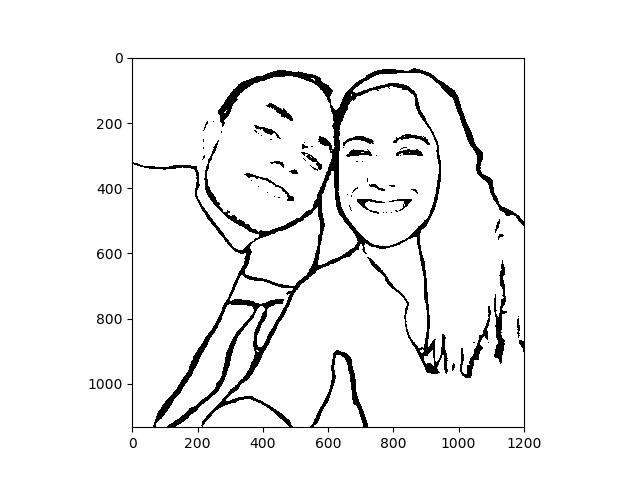

In [51]:
bw_qimage = rgb2gray(quantized_image)
bw_qimage[bw_qimage >= 0.5] = 1
bw_qimage[bw_qimage < 0.5] = 0
plt.imshow(bw_qimage, cmap='gray');plt.show()

Now for DBSCAN, I keep in mind that every point is at a minimum 1 unit of distance away from the other. I set this, the eps parameter, as the minimum distance for defining clusters.

In [37]:
from sklearn.cluster import DBSCAN
pts = np.array(np.where(bw_qimage == 0))
db = DBSCAN(eps=1).fit(pts.T)
labels = db.labels_
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
clust_sizes = [(labels==l).sum() for l in unique_labels]

<IPython.core.display.Javascript object>


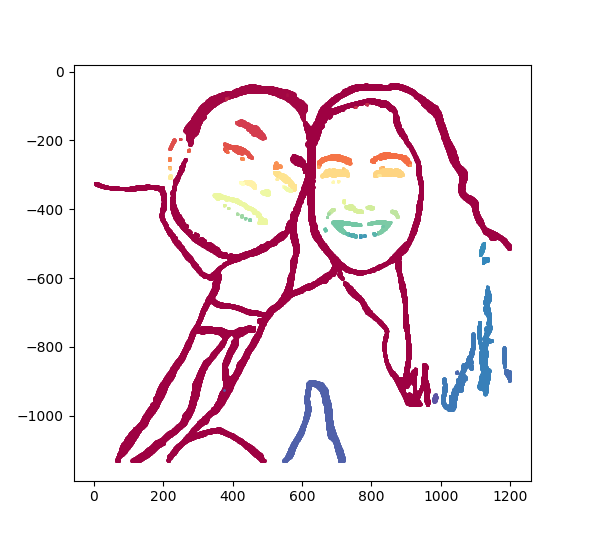

In [38]:
from matplotlib import transforms
fig, ax = plt.subplots()
base = ax.transData
rot = transforms.Affine2D().rotate_deg(-90)
for l,c in zip(unique_labels, colors):
    if l == -1:
        continue
    clust = pts.T[labels==l]
    ax.scatter(clust.T[0], clust.T[1], color=c, transform=rot+base, s=1)
plt.show()

Well, there is some potential here... However, now I have to solve an even bigger problem! How do I segment these clusters into contiguous regions that are amenable to approximation? For example, look at the largest cluster below.

<IPython.core.display.Javascript object>


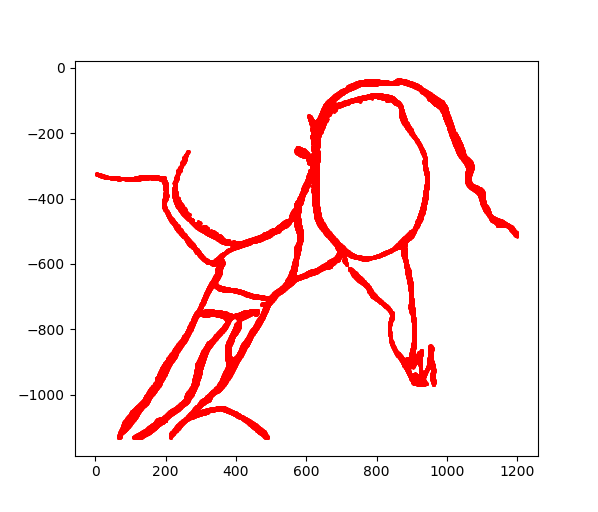

In [39]:
fig, ax = plt.subplots()
base = ax.transData
rot = transforms.Affine2D().rotate_deg(-90)
for l,c in zip([0], [(1.0,0,0)]):
    if l == -1:
        continue
    clust = pts.T[labels==l]
    ax.scatter(clust.T[0], clust.T[1], color=c, transform=rot+base, s=1)
plt.show()

This is one continuous cluster. For standard least squares approximation, I would need to somehow break this giant cluster into segments that are more or less monotonic in x. That is a difficult problem in itself. In addition, how does one handle intersections? We can side step the monotonicity constraint if we approximate it with a parameteric curve, but we are still faced with resolving intersections... So... All in all my plan sucks. I need to come up with another idea...

...Time passes...

Alright, new idea! Instead of approximating 1D curves through the edges of our faces, I will just approximate a 2D quadratic surface through every small window in the entire image! I should have started with this idea. This is much more elegant, as it will not require all the preprocessing in GIMP so I won't be 'cheating'. As if this is some contest with myself to automate as much of this process as possible... Anyway, we will soon see if it is as easy as I suspect!

First we create a small routine for fitting a degree $n$ quadric surface to an arbitrary number of points.

In [40]:
from numpy.polynomial import polynomial
def polyfit2d(x, y, f, deg):
    vander = polynomial.polyvander2d(x, y, deg)
    vander = vander.reshape((-1,vander.shape[-1]))
    f = f.reshape((vander.shape[0],))
    c = np.linalg.lstsq(vander, f)[0]
    return c.reshape(deg+1)

This should be complete in two passes. First, we will learn all the coefficients of the quadric surfaces and save them along with the bounds of x and y where they are defined. Next we will create a new image where we 'plot' the quadric surfaces over their domains. However, to create a good looking image we need the windows to be much smaller than the image dimensions. So that I do not have 190,000 equations (which I did when I first ran this) I will crop and downsample our original image. The final image that I am going to turn into math is the following

<IPython.core.display.Javascript object>


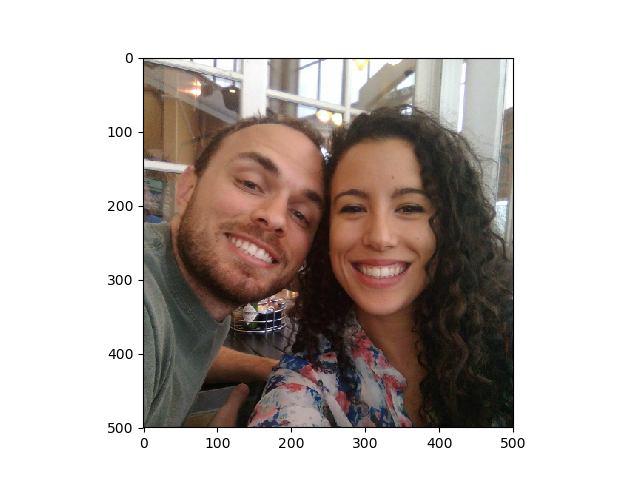

In [21]:
crop_img = plt.imread('n&n_crop.jpg')
plt.imshow(crop_img); plt.show()

Now just to prove how well this new method works, I am going to approximate high order quadric surfaces on small windows, this is the mathematical equivalent of "high resolution". The results look great. In fact, with this technique, I even have sub pixel accuracy in each window, I could theoretically increase the resolution of the original image. But we'd still have to address the edges between the windows. I bet just allowing the windows to overlap by one pixel would fix that! Anyway, that is a project for another day. Back to turning my girlfriend's curves into equations.

So if you have the code toggled off, you do not see, but below here are the two phases mentioned above. I am running this with a window of 5 pixels and fitting a fourth order polynomial to the 25 pixels.

In [42]:
gray_image = rgb2gray(crop_img)
#gray_image = rgb2gray(full_image)
img_shape = gray_image.shape
step_sz = 5
deg = np.array([4,4])
x_steps = np.arange(0,img_shape[0],step_sz)
y_steps = np.arange(0,img_shape[1],step_sz)
num_eqns = 0
data_struct = {}
for xidx in x_steps:
    for yidx in y_steps:
        f = gray_image[xidx:xidx+step_sz, yidx:yidx+step_sz]
        x = np.arange(xidx,xidx+step_sz)
        y = np.arange(yidx,yidx+step_sz)
        X,Y = np.meshgrid(x,y)
        coeffs = polyfit2d(X,Y,f,deg)
        data_struct[num_eqns] = {'c':coeffs, 'xlims':(xidx,xidx+step_sz), 'ylims':(yidx,yidx+step_sz)}
        num_eqns += 1

In [43]:
reconstruction = np.ndarray(img_shape)
num_eqns = 0
for xidx in x_steps:
    for yidx in y_steps:
        x = np.arange(xidx,xidx+step_sz)
        y = np.arange(yidx,yidx+step_sz)
        X,Y = np.meshgrid(x,y)
        c = data_struct[num_eqns]['c']
        reconstruction[xidx:xidx+step_sz, yidx:yidx+step_sz] = polynomial.polyval2d(X, Y, c)
        coeffs = polyfit2d(X,Y,f,deg)
        data_struct[num_eqns] = {'c':coeffs, 'xlims':(xidx,xidx+step_sz), 'ylims':(yidx,yidx+step_sz)}
        num_eqns += 1

And as we can see below, the results are EXCELLENT! That entire image below is generated from a set of continuous equations. Pretty cool. However, to do this I needed 10,000 equations. Not a problem for a computer, but a big problem for a person. I want to print the equations out and give them to her in some twisted, nerdy, romantic way. At least that is the illusion I'm currently under. So I'm going to increase the window size. We'll lose a bit of the beauty, but I can then at least extract the equations.

<IPython.core.display.Javascript object>


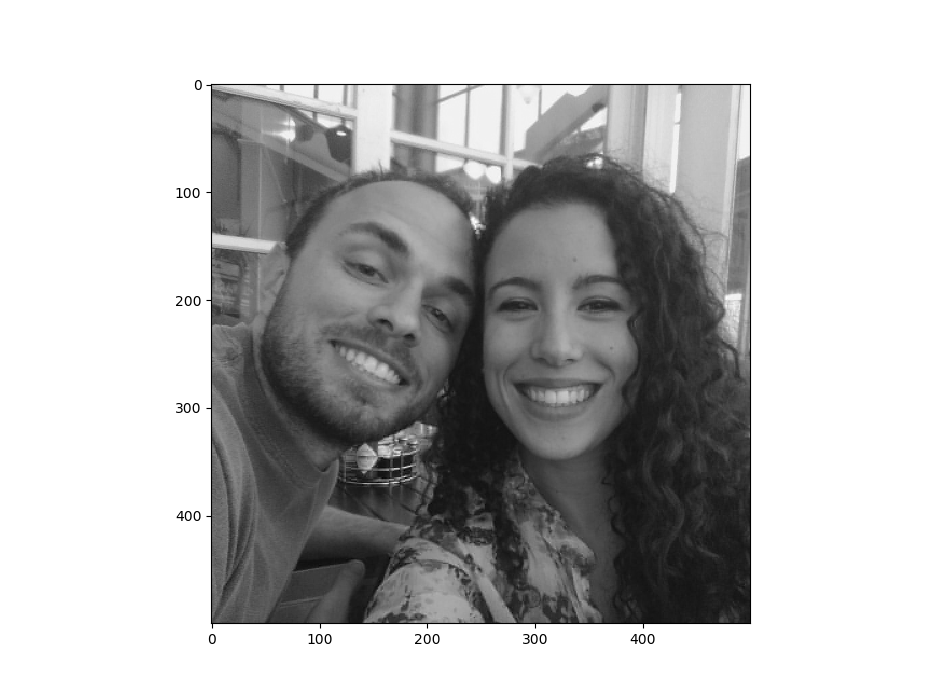

In [44]:
plt.imshow(reconstruction,cmap='gray'); plt.show()

In [46]:
gray_image = rgb2gray(crop_img)
#gray_image = rgb2gray(full_image)
img_shape = gray_image.shape
step_sz = 20
deg = np.array([4,4])
x_steps = np.arange(0,img_shape[0],step_sz)
y_steps = np.arange(0,img_shape[1],step_sz)
num_eqns = 0
data_struct = {}
for xidx in x_steps:
    for yidx in y_steps:
        f = gray_image[xidx:xidx+step_sz, yidx:yidx+step_sz]
        x = np.arange(xidx,xidx+step_sz)
        y = np.arange(yidx,yidx+step_sz)
        X,Y = np.meshgrid(x,y)
        coeffs = polyfit2d(X,Y,f,deg)
        data_struct[num_eqns] = {'c':coeffs, 'xlims':(xidx,xidx+step_sz), 'ylims':(yidx,yidx+step_sz)}
        num_eqns += 1

In [47]:
reconstruction = np.ndarray(img_shape)
num_eqns = 0
for xidx in x_steps:
    for yidx in y_steps:
        x = np.arange(xidx,xidx+step_sz)
        y = np.arange(yidx,yidx+step_sz)
        X,Y = np.meshgrid(x,y)
        c = data_struct[num_eqns]['c']
        reconstruction[xidx:xidx+step_sz, yidx:yidx+step_sz] = polynomial.polyval2d(X, Y, c)
        coeffs = polyfit2d(X,Y,f,deg)
        data_struct[num_eqns] = {'c':coeffs, 'xlims':(xidx,xidx+step_sz), 'ylims':(yidx,yidx+step_sz)}
        num_eqns += 1

<IPython.core.display.Javascript object>


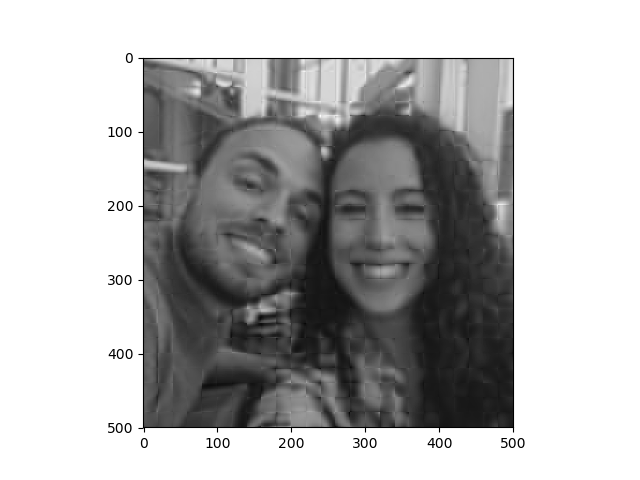

In [48]:
plt.imshow(reconstruction,cmap='gray'); plt.show()

Ya... Not nearly as beautiful... Well I probably look more beautiful... However we can now express this entire image in less equations. Now the super unglamorous part of formatting some text output to combine the coefficients with the polynomial terms and their bounds... That code is below.

In [64]:
equations = []
for k,v in data_struct.items():
    equation = "$$\scriptsize"
    for e in range((deg[0]+1)*(deg[1]+1)):
        i = e//(deg[0]+1)
        j = e%(deg[1]+1)
        c = v['c']
        if np.abs(c[i,j]) <= 1e-3:
            continue
        term = "%0.3f" % (np.around(c[i,j],3))
        if i > 1:
            term += "x^%d" % (i)
        elif i == 1:
            term += "x"
        if j > 1:
            term += "y^%d" % (j)
        elif j == 1:
            term += "y"
        if e != 0 and c[i,j] > 0:
            equation += "+"+term
        else:
            equation += term
    if equation == "$$\scriptsize":
        continue
    xbounds = r"\hspace{10pt} %d \le x \le %d" % (v['xlims'][0], v['xlims'][1])
    ybounds = r"\hspace{10pt} %d \le y \le %d" % (v['ylims'][0], v['ylims'][1])
    equations.append(equation + xbounds + ybounds + "$$")

In [65]:
for eq in equations:
    print(eq)

$$\scriptsize0.065+0.016y-0.003y^2+0.014x-0.007xy+0.003xy^2-0.001x^2\hspace{10pt} 0 \le x \le 20\hspace{10pt} 0 \le y \le 20$$
$$\scriptsize-3.559+0.490y-0.024y^2+4.652x-0.676xy+0.036xy^2-0.620x^2+0.096x^2y-0.005x^2y^2+0.023x^3-0.004x^3y\hspace{10pt} 0 \le x \le 20\hspace{10pt} 20 \le y \le 40$$
$$\scriptsize9.512-0.842y+0.028y^2+13.024x-1.089xy+0.034xy^2-0.636x^2+0.070x^2y-0.003x^2y^2-0.102x^3+0.006x^3y+0.005x^4\hspace{10pt} 0 \le x \le 20\hspace{10pt} 40 \le y \le 60$$
$$\scriptsize0.688-0.170y+0.007y^2+3.328x-0.205xy+0.004xy^2+12.113x^2-0.672x^2y+0.014x^2y^2-1.631x^3+0.091x^3y-0.002x^3y^2+0.053x^4-0.003x^4y\hspace{10pt} 0 \le x \le 20\hspace{10pt} 60 \le y \le 80$$
$$\scriptsize-0.010-0.221y+0.007y^2+0.004x+0.007xy+0.034x^2+0.043x^2y-0.001x^2y^2+0.235x^3-0.017x^3y-0.012x^4\hspace{10pt} 0 \le x \le 20\hspace{10pt} 80 \le y \le 100$$
$$\scriptsize-0.011-0.335y+0.009y^2+0.009x+0.037xy-0.001xy^2+0.077x^2+0.059x^2y-0.002x^2y^2+0.544x^3-0.029x^3y-0.027x^4+0.001x^4y\hspace{10pt} 0 \le x \l

And that is it... The below equations are a mathematical representation of me falling in love with my girlfriend.

$$\scriptsize0.065+0.016y-0.003y^2+0.014x-0.007xy+0.003xy^2-0.001x^2\hspace{10pt} 0 \le x \le 20\hspace{10pt} 0 \le y \le 20$$
$$\scriptsize-3.559+0.490y-0.024y^2+4.652x-0.676xy+0.036xy^2-0.620x^2+0.096x^2y-0.005x^2y^2+0.023x^3-0.004x^3y\hspace{10pt} 0 \le x \le 20\hspace{10pt} 20 \le y \le 40$$
$$\scriptsize9.512-0.842y+0.028y^2+13.024x-1.089xy+0.034xy^2-0.636x^2+0.070x^2y-0.003x^2y^2-0.102x^3+0.006x^3y+0.005x^4\hspace{10pt} 0 \le x \le 20\hspace{10pt} 40 \le y \le 60$$
$$\scriptsize0.688-0.170y+0.007y^2+3.328x-0.205xy+0.004xy^2+12.113x^2-0.672x^2y+0.014x^2y^2-1.631x^3+0.091x^3y-0.002x^3y^2+0.053x^4-0.003x^4y\hspace{10pt} 0 \le x \le 20\hspace{10pt} 60 \le y \le 80$$
$$\scriptsize-0.010-0.221y+0.007y^2+0.004x+0.007xy+0.034x^2+0.043x^2y-0.001x^2y^2+0.235x^3-0.017x^3y-0.012x^4\hspace{10pt} 0 \le x \le 20\hspace{10pt} 80 \le y \le 100$$
$$\scriptsize-0.011-0.335y+0.009y^2+0.009x+0.037xy-0.001xy^2+0.077x^2+0.059x^2y-0.002x^2y^2+0.544x^3-0.029x^3y-0.027x^4+0.001x^4y\hspace{10pt} 0 \le x \le 20\hspace{10pt} 100 \le y \le 120$$
$$\scriptsize-0.015-0.473y+0.011y^2+0.002x+0.079xy-0.002xy^2+0.003x^2+0.081x^2y-0.002x^2y^2-0.012x^3y+0.010x^4\hspace{10pt} 0 \le x \le 20\hspace{10pt} 120 \le y \le 140$$
$$\scriptsize-0.005-0.172y+0.003y^2-0.005x-0.204xy+0.004xy^2+0.005x^2+0.168x^2y-0.003x^2y^2-0.021x^3y+0.017x^4\hspace{10pt} 0 \le x \le 20\hspace{10pt} 140 \le y \le 160$$
$$\scriptsize+0.007y+0.034xy-0.001xy^2+0.003x^2+0.124x^2y-0.002x^2y^2+0.001x^3-0.019x^3y+0.029x^4\hspace{10pt} 0 \le x \le 20\hspace{10pt} 160 \le y \le 180$$
$$\scriptsize+0.009y+0.043xy-0.001xy^2+0.003x^2+0.156x^2y-0.002x^2y^2+0.002x^3-0.024x^3y+0.046x^4\hspace{10pt} 0 \le x \le 20\hspace{10pt} 180 \le y \le 200$$
$$\scriptsize+0.011y+0.001x+0.053xy-0.001xy^2+0.004x^2+0.192x^2y-0.003x^2y^2+0.003x^3-0.029x^3y+0.069x^4\hspace{10pt} 0 \le x \le 20\hspace{10pt} 200 \le y \le 220$$
$$\scriptsize+0.013y+0.001x+0.064xy-0.001xy^2+0.004x^2+0.232x^2y-0.003x^2y^2-0.035x^3y+0.001x^4y\hspace{10pt} 0 \le x \le 20\hspace{10pt} 220 \le y \le 240$$
$$\scriptsize-0.003x^3y\hspace{10pt} 0 \le x \le 20\hspace{10pt} 240 \le y \le 260$$
$$\scriptsize-0.004x^3y\hspace{10pt} 0 \le x \le 20\hspace{10pt} 260 \le y \le 280$$
$$\scriptsize-0.004x^3y\hspace{10pt} 0 \le x \le 20\hspace{10pt} 280 \le y \le 300$$
$$\scriptsize-0.005x^3y\hspace{10pt} 0 \le x \le 20\hspace{10pt} 300 \le y \le 320$$
$$\scriptsize-0.005x^3y\hspace{10pt} 0 \le x \le 20\hspace{10pt} 320 \le y \le 340$$
$$\scriptsize-0.006x^3y\hspace{10pt} 0 \le x \le 20\hspace{10pt} 340 \le y \le 360$$
$$\scriptsize-0.006x^3y\hspace{10pt} 0 \le x \le 20\hspace{10pt} 360 \le y \le 380$$
$$\scriptsize-0.007x^3y\hspace{10pt} 0 \le x \le 20\hspace{10pt} 380 \le y \le 400$$
$$\scriptsize-0.001x^2y-0.008x^3y\hspace{10pt} 0 \le x \le 20\hspace{10pt} 400 \le y \le 420$$
$$\scriptsize-0.001x^2y-0.009x^3y\hspace{10pt} 0 \le x \le 20\hspace{10pt} 420 \le y \le 440$$
$$\scriptsize-0.001x^2y-0.009x^3y\hspace{10pt} 0 \le x \le 20\hspace{10pt} 440 \le y \le 460$$
$$\scriptsize-0.048-1.644y-0.158y^2+0.039y^3-0.001y^4-0.063x+0.301xy+0.008xy^2-0.005xy^3+0.008x^2-0.019x^2y\hspace{10pt} 20 \le x \le 40\hspace{10pt} 0 \le y \le 20$$
$$\scriptsize-0.255+14.930y-1.522y^2+0.049y^3-16.705x+0.107xy+0.108xy^2-0.005xy^3+1.765x^2-0.124x^2y-0.060x^3+0.005x^3y\hspace{10pt} 20 \le x \le 40\hspace{10pt} 20 \le y \le 40$$
$$\scriptsize-0.003-0.063y+0.085y^2-0.004y^3-0.008x-0.479xy+0.019xy^2+0.303x^2+0.026x^2y-0.002x^2y^2-0.015x^3\hspace{10pt} 20 \le x \le 40\hspace{10pt} 40 \le y \le 60$$
$$\scriptsize-0.008-0.136y+0.110y^2-0.003y^3-0.057x-0.990xy+0.029xy^2+0.007x^2+0.105x^2y-0.004x^2y^2+0.019x^3-0.005x^3y\hspace{10pt} 20 \le x \le 40\hspace{10pt} 60 \le y \le 80$$
$$\scriptsize+0.004y+0.116y^2-0.003y^3-0.016xy^2+0.003x^2+0.003x^2y+0.052x^3-0.003x^3y-0.001x^4\hspace{10pt} 20 \le x \le 40\hspace{10pt} 80 \le y \le 100$$
$$\scriptsize+0.003y+0.124y^2-0.002y^3-0.017xy^2+0.008x^2+0.005x^2y+0.116x^3-0.005x^3y-0.003x^4\hspace{10pt} 20 \le x \le 40\hspace{10pt} 100 \le y \le 120$$
$$\scriptsize+0.007x^2y\hspace{10pt} 20 \le x \le 40\hspace{10pt} 120 \le y \le 140$$
$$\scriptsize+0.001xy+0.010x^2y+0.001x^4\hspace{10pt} 20 \le x \le 40\hspace{10pt} 140 \le y \le 160$$
$$\scriptsize+0.001xy+0.013x^2y+0.002x^4\hspace{10pt} 20 \le x \le 40\hspace{10pt} 160 \le y \le 180$$
$$\scriptsize+0.003x^4\hspace{10pt} 20 \le x \le 40\hspace{10pt} 180 \le y \le 200$$
$$\scriptsize+0.005x^4\hspace{10pt} 20 \le x \le 40\hspace{10pt} 200 \le y \le 220$$
$$\scriptsize-7.060-10.095y-1.953y^2+0.383y^3-0.012y^4+0.347x+1.016xy+0.121xy^2-0.029xy^3-0.003x^2-0.037x^2y-0.003x^2y^2\hspace{10pt} 40 \le x \le 60\hspace{10pt} 0 \le y \le 20$$
$$\scriptsize-0.004-0.027y+0.056y^2-0.017y^3-0.056x-0.392xy+0.039xy^2+0.005x^2+0.024x^2y-0.003x^2y^2\hspace{10pt} 40 \le x \le 60\hspace{10pt} 20 \le y \le 40$$
$$\scriptsize-0.004y^3+0.002xy^2+0.001x^3\hspace{10pt} 40 \le x \le 60\hspace{10pt} 40 \le y \le 60$$
$$\scriptsize-0.002y^3+0.002xy^2+0.005x^3\hspace{10pt} 40 \le x \le 60\hspace{10pt} 60 \le y \le 80$$
$$\scriptsize-0.001y^3+0.002xy^2+0.014x^3\hspace{10pt} 40 \le x \le 60\hspace{10pt} 80 \le y \le 100$$
$$\scriptsize+0.002xy^2\hspace{10pt} 40 \le x \le 60\hspace{10pt} 100 \le y \le 120$$
$$\scriptsize+0.002xy^2+0.001x^2y\hspace{10pt} 40 \le x \le 60\hspace{10pt} 120 \le y \le 140$$
$$\scriptsize+0.002xy^2\hspace{10pt} 40 \le x \le 60\hspace{10pt} 140 \le y \le 160$$
$$\scriptsize+0.002xy^2\hspace{10pt} 40 \le x \le 60\hspace{10pt} 160 \le y \le 180$$
$$\scriptsize+0.002xy^2\hspace{10pt} 40 \le x \le 60\hspace{10pt} 180 \le y \le 200$$
$$\scriptsize+0.002xy^2\hspace{10pt} 40 \le x \le 60\hspace{10pt} 200 \le y \le 220$$
$$\scriptsize-1.093-5.078y-18.559y^2+2.471y^3-0.075y^4-0.406x+0.659xy+0.999xy^2-0.138xy^3+0.004xy^4+0.019x^2-0.022x^2y-0.020x^2y^2+0.003x^2y^3\hspace{10pt} 60 \le x \le 80\hspace{10pt} 0 \le y \le 20$$
$$\scriptsize-0.006-0.044y+0.002y^2-0.051y^3+0.002y^4-0.108x-0.754xy+0.084xy^2-0.006x^2+0.034x^2y-0.004x^2y^2\hspace{10pt} 60 \le x \le 80\hspace{10pt} 20 \le y \le 40$$
$$\scriptsize-0.017y^3+0.005xy^2\hspace{10pt} 60 \le x \le 80\hspace{10pt} 40 \le y \le 60$$
$$\scriptsize-0.008y^3+0.004xy^2+0.002x^3\hspace{10pt} 60 \le x \le 80\hspace{10pt} 60 \le y \le 80$$
$$\scriptsize-0.005y^3+0.004xy^2+0.006x^3\hspace{10pt} 60 \le x \le 80\hspace{10pt} 80 \le y \le 100$$
$$\scriptsize-0.003y^3+0.004xy^2\hspace{10pt} 60 \le x \le 80\hspace{10pt} 100 \le y \le 120$$
$$\scriptsize-0.002y^3+0.004xy^2\hspace{10pt} 60 \le x \le 80\hspace{10pt} 120 \le y \le 140$$
$$\scriptsize-0.002y^3\hspace{10pt} 60 \le x \le 80\hspace{10pt} 140 \le y \le 160$$
$$\scriptsize-0.001y^3\hspace{10pt} 60 \le x \le 80\hspace{10pt} 160 \le y \le 180$$
$$\scriptsize-0.001y^3\hspace{10pt} 60 \le x \le 80\hspace{10pt} 180 \le y \le 200$$
$$\scriptsize-0.036+0.021y-0.058y^2-0.378y^3+0.034y^4-0.782x+0.598xy-0.124xy^2+0.025xy^3-0.002xy^4+0.026x^2-0.020x^2y+0.004x^2y^2\hspace{10pt} 80 \le x \le 100\hspace{10pt} 0 \le y \le 20$$
$$\scriptsize-0.009y^2-0.140y^3+0.004y^4+0.008xy^2+0.006xy^3-0.017x^2+0.002x^2y\hspace{10pt} 80 \le x \le 100\hspace{10pt} 20 \le y \le 40$$
$$\scriptsize-0.002y^2-0.047y^3+0.008xy^2+0.002xy^3\hspace{10pt} 80 \le x \le 100\hspace{10pt} 40 \le y \le 60$$
$$\scriptsize-0.023y^3+0.007xy^2+0.001x^3\hspace{10pt} 80 \le x \le 100\hspace{10pt} 60 \le y \le 80$$
$$\scriptsize+0.007xy^2-0.001x^2y\hspace{10pt} 80 \le x \le 100\hspace{10pt} 80 \le y \le 100$$
$$\scriptsize-0.044+0.021y-0.117y^2-0.796y^3+0.072y^4-1.175x+0.889xy-0.184xy^2+0.041xy^3-0.003xy^4+0.032x^2-0.024x^2y+0.005x^2y^2\hspace{10pt} 100 \le x \le 120\hspace{10pt} 0 \le y \le 20$$
$$\scriptsize-0.020y^2-0.311y^3+0.010y^4+0.001xy+0.012xy^2+0.011xy^3-0.021x^2+0.003x^2y\hspace{10pt} 100 \le x \le 120\hspace{10pt} 20 \le y \le 40$$
$$\scriptsize+0.011xy^2\hspace{10pt} 100 \le x \le 120\hspace{10pt} 40 \le y \le 60$$
$$\scriptsize-0.051+0.038y-0.008y^2+0.003y^3+0.051y^4-1.645x+1.237xy-0.262xy^2+0.017xy^3-0.002xy^4+0.038x^2-0.029x^2y+0.006x^2y^2\hspace{10pt} 120 \le x \le 140\hspace{10pt} 0 \le y \le 20$$
$$\scriptsize+0.002y^4+0.002xy+0.016xy^2-0.001xy^3\hspace{10pt} 120 \le x \le 140\hspace{10pt} 20 \le y \le 40$$
$$\scriptsize+0.015xy^2\hspace{10pt} 120 \le x \le 140\hspace{10pt} 40 \le y \le 60$$
$$\scriptsize+0.005y^3+0.091y^4+0.030x+0.034xy-0.036xy^2-0.002xy^4\hspace{10pt} 140 \le x \le 160\hspace{10pt} 0 \le y \le 20$$
$$\scriptsize+0.003y^4+0.002xy+0.021xy^2-0.002xy^3\hspace{10pt} 140 \le x \le 160\hspace{10pt} 20 \le y \le 40$$
$$\scriptsize+0.009y^3+0.152y^4-0.002x-0.008xy-0.031xy^2-0.001xy^3-0.003xy^4\hspace{10pt} 160 \le x \le 180\hspace{10pt} 0 \le y \le 20$$
$$\scriptsize+0.005y^4+0.003xy+0.027xy^2-0.002xy^3\hspace{10pt} 160 \le x \le 180\hspace{10pt} 20 \le y \le 40$$
$$\scriptsize+0.014y^3+0.238y^4-0.002x-0.011xy-0.039xy^2-0.001xy^3-0.005xy^4\hspace{10pt} 180 \le x \le 200\hspace{10pt} 0 \le y \le 20$$
$$\scriptsize+0.007y^4\hspace{10pt} 180 \le x \le 200\hspace{10pt} 20 \le y \le 40$$
$$\scriptsize+0.021y^3+0.356y^4-0.003x-0.013xy-0.048xy^2-0.002xy^3-0.007xy^4\hspace{10pt} 200 \le x \le 220\hspace{10pt} 0 \le y \le 20$$
$$\scriptsize+0.011y^4\hspace{10pt} 200 \le x \le 220\hspace{10pt} 20 \le y \le 40$$
$$\scriptsize+0.001y^4\hspace{10pt} 200 \le x \le 220\hspace{10pt} 40 \le y \le 60$$
$$\scriptsize-0.001y^2-0.003x-0.016xy-0.058xy^2-0.002xy^3\hspace{10pt} 220 \le x \le 240\hspace{10pt} 0 \le y \le 20$$
$$\scriptsize-0.002xy^2-0.011xy^3\hspace{10pt} 240 \le x \le 260\hspace{10pt} 0 \le y \le 20$$
$$\scriptsize-0.002xy^2-0.013xy^3\hspace{10pt} 260 \le x \le 280\hspace{10pt} 0 \le y \le 20$$
$$\scriptsize-0.002xy^2-0.015xy^3\hspace{10pt} 280 \le x \le 300\hspace{10pt} 0 \le y \le 20$$
$$\scriptsize-0.002xy^2-0.017xy^3\hspace{10pt} 300 \le x \le 320\hspace{10pt} 0 \le y \le 20$$
$$\scriptsize-0.003xy^2-0.020xy^3+0.001xy^4\hspace{10pt} 320 \le x \le 340\hspace{10pt} 0 \le y \le 20$$
$$\scriptsize-0.001xy^3\hspace{10pt} 320 \le x \le 340\hspace{10pt} 20 \le y \le 40$$
$$\scriptsize-0.003xy^2-0.022xy^3+0.001xy^4\hspace{10pt} 340 \le x \le 360\hspace{10pt} 0 \le y \le 20$$
$$\scriptsize-0.001xy^3\hspace{10pt} 340 \le x \le 360\hspace{10pt} 20 \le y \le 40$$
$$\scriptsize-0.003xy^2-0.025xy^3+0.001xy^4\hspace{10pt} 360 \le x \le 380\hspace{10pt} 0 \le y \le 20$$
$$\scriptsize-0.001xy^3\hspace{10pt} 360 \le x \le 380\hspace{10pt} 20 \le y \le 40$$
$$\scriptsize-0.004xy^2-0.027xy^3+0.001xy^4\hspace{10pt} 380 \le x \le 400\hspace{10pt} 0 \le y \le 20$$
$$\scriptsize-0.001xy^3\hspace{10pt} 380 \le x \le 400\hspace{10pt} 20 \le y \le 40$$
$$\scriptsize-0.004xy^2-0.030xy^3+0.002xy^4\hspace{10pt} 400 \le x \le 420\hspace{10pt} 0 \le y \le 20$$
$$\scriptsize-0.005xy^2-0.033xy^3+0.002xy^4\hspace{10pt} 420 \le x \le 440\hspace{10pt} 0 \le y \le 20$$
$$\scriptsize-0.005xy^2-0.036xy^3+0.002xy^4\hspace{10pt} 440 \le x \le 460\hspace{10pt} 0 \le y \le 20$$